# 0 - Import pakietów

In [1]:
import string
import os
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np

from joblib import Parallel, delayed
from pandas import read_csv
from tqdm import tqdm

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import contractions
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from itertools import combinations
from sklearn.compose import ColumnTransformer

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bordo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bordo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bordo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

---
# 1 - Pobranie danych

### 1.1 - Wczytanie pierwotnych danych

Dane umieszczone w lokalnych folderach projektu, a dokładniej w folderze `dane`.

In [2]:
train_df = pd.read_csv('data/train.csv', header=None, names=['opinion', 'title', 'content'])

In [3]:
test_df = pd.read_csv('data/test.csv', header=None, names=['opinion', 'title', 'content'])

Wyświetlenie pierwszych wierszy obu zbiorów danych:

In [4]:
train_df.head()

,opinion,title,content
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [5]:
test_df.head()

,opinion,title,content
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   opinion  int64 
 1   title    object
 2   content  object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   opinion  400000 non-null  int64 
 1   title    399976 non-null  object
 2   content  400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


Stworzenie listy zawierającej odniesienie do zbioru treningowego i testowego do działania na całości.

In [8]:
full_df = [train_df, test_df]

---
# 2 - Czyszczenie danych

Sprawdzenie, czy dane zwierają puste atrybyuty:

In [9]:
nan_sum = 0
for df in full_df:
    nan_sum += df.isna().sum()

print(nan_sum)

opinion      0
title      231
content      0
dtype: int64


Występują puste atrybuty w kolumnie *title*. W celu obsłużenia pustych danych, pozbywam się wszystkich kolumn, które takie dane zawierają oraz wyświetlam wynik:

In [10]:
for df in full_df:
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

nan_sum = 0
for df in full_df:
    nan_sum += df.isna().sum()

print(nan_sum)

opinion    0
title      0
content    0
dtype: int64


---
# 3 - Przetwarzanie wstępne

### 3.1 - Przetworzenie tekstu do odpowiednich jednostek słownych

In [17]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
punctuation.update(["``", "''", "“", "”", "‘", "’", "«", "»", "„", "`", "´", "′", "″"])
punctuation_str = ''.join([p for p in punctuation if len(p) == 1])

Funkcja mająca na celu przetworzenie danych tekstowych, aby podzielić zbiory wyrazów na pojedyncze jednostki słowne do dalszej analizy. Co się wykonuje:
- rozwinięcie kontrakcji na pełne wyrażenia;
- zamiana wszystkich liter na małe;
- tokenizacja;
- usuwanie znaków interpunkcyjnych;
- usuwanie słów mało znaczącaych w analizie takich jak spójniki i inne (zbiór *stopwords* w bibliotece NLTK);
- lematyzacja;
- stemming;

Gdzie na wyjście podawany jest do wyboru efekt tokenizacji, stemmingu lub lematyzacji.

In [18]:
def preprocess_text(text,
                    use_tokenization=False,
                    use_stemming=False,
                    use_lemmatization=False):
    """
    Parametry:
        - text                  : string, tekst do przetwarzania
        - use_stemming          : czy stosować stemming
        - use_lemmatization     : czy stosować lematyzację
        - use_tokenization      : czy zapisać efekt tokenizacji

    Wyjście:
        Słownik na wzór:
        {"stemmed": "very nice", "lemmatized": "very nice"}
    """

    # Rozwijnie kontrakcji ("I've -> I have" itp.)
    text = contractions.fix(text)

    # Zamiana na małe litery
    text = text.lower()

    # Tokenizacja
    tokens = word_tokenize(text)

    # Usunięcie znaków interpunkcyjnych
    filtered_tokens = [t.translate(str.maketrans('', '', punctuation_str)) for t in tokens]

    # Usunięcie stopwords (zbiór słów "pomijalnych" z NLTK)
    filtered_stopwords_tokens = []
    for t in filtered_tokens:
        if t in stop_words:
            continue
        filtered_stopwords_tokens.append(t)

    filtered_tokens = filtered_stopwords_tokens

    # Opcjonalny zapis do ramki wyjściowej efektów tokenizacji (samej), stemmingu lub lematyzacji
    output = {}
    if use_tokenization:
        output["tokenized"] = " ".join(tokens)

    if use_stemming:
        stemmed = [stemmer.stem(t) for t in filtered_tokens]
        output["stemmed"] = " ".join(stemmed)

    if use_lemmatization:
        lemmatized = [lemmatizer.lemmatize(t) for t in filtered_tokens]
        output["lemmatized"] = " ".join(lemmatized)

    return output

In [19]:
def batch_preprocess_columns(
    df_og,
    columns_to_preprocess,  # np. ["title", "content"]
    suffixes={"tokenized": "_tokenized", "stemmed": "_stemmed", "lemmatized": "_lemmatized"},    # jaki dopisek do nazwy kolumny
    use_tokenization=False,
    use_stemming=False,
    use_lemmatization=False,
    output_path="processed_text.txt",
    n_jobs=-1,
    verbose=10
):
    """
    Przetwarza (równolegle) wskazane kolumny DataFrame, wywołując `preprocess_text`
    dla każdego wiersza w kolumnie.
    - df                    : wejściowy DataFrame
    - columns_to_preprocess : lista nazw kolumn do przetwarzania (np. ["title", "content"])
    - suffixes              : string, np. "_processed", "_stemmed", itp. Zostanie dodany do nazwy.
    - use_tokenization, use_stemming, use_lemmatization:
        parametry przekazywane do `preprocess_text`
    - n_jobs                : ile równoległych zadań (jobów). -1 = użyj wszystkich rdzeni
    - verbose               : poziom szczegółowości logów joblib / tqdm

    Zwraca nowy DataFrame z dodatkowymi kolumnami <nazwa_kolumny> + <suffix>.
    """

    df = df_og.copy()
    result = pd.DataFrame()

    for col in columns_to_preprocess:
        texts = df[col].astype(str).tolist()

        # Przetwarzanie równoległe
        processed = Parallel(n_jobs=n_jobs, verbose=verbose)(
            delayed(preprocess_text)(
                text,
                use_stemming=use_stemming,
                use_lemmatization=use_lemmatization,
                use_tokenization=use_tokenization
            )
            for text in tqdm(texts, desc=f"Przetwarzanie kolumny {col}")
        )

        if use_tokenization:
            result[col + suffixes["tokenized"]] = [r.get("tokenized", "") for r in processed]

        if use_stemming:
            result[col + suffixes["stemmed"]] = [r.get("stemmed", "") for r in processed]

        if use_lemmatization:
            result[col + suffixes["lemmatized"]] = [r.get("lemmatized", "") for r in processed]

    return result

In [20]:
def process_or_read(train_file, test_file, train_df, test_df):
    if os.path.isfile(train_file):
        proc_train = read_csv(train_file, header=0)
    else:
        proc_train = batch_preprocess_columns(
            train_df,
            columns_to_preprocess=["title", "content"],
            use_tokenization=False,
            use_stemming=True,
            use_lemmatization=True,
            output_path=train_file,
            verbose=0)

    if os.path.isfile(test_file):
        proc_test = read_csv(test_file, header=0)
    else:
        proc_test = batch_preprocess_columns(
            test_df,
            columns_to_preprocess=["title", "content"],
            use_tokenization=False,
            use_stemming=True,
            use_lemmatization=True,
            output_path=test_file,
        )

    train_df = pd.concat([train_df, proc_train], axis=1)
    test_df = pd.concat([test_df, proc_test], axis=1)
    train_df['full_lematized'] = train_df['title_lemmatized'] + " " + train_df['content_lemmatized']
    test_df['full_lematized'] = test_df['title_lemmatized'] + " " + test_df['content_lemmatized']
    full_df = (train_df, test_df)
    return full_df

In [21]:
train_file = "train_opinions_processed_lemmatized.csv"
test_file = "test_opinions_processed_lemmatized.csv"

In [22]:
proc_train_df, proc_test_df = process_or_read(train_file, test_file, train_df, test_df)

In [23]:
proc_train_df.head()

,opinion,title,content,title_lemmatized,content_lemmatized,full_lematized
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,stuning even nongamer,sound track beautiful paint senery mind well ...,stuning even nongamer sound track beautiful p...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,best soundtrack ever anything,reading lot review saying best game soundtrack...,best soundtrack ever anything reading lot rev...
2,2,Amazing!,This soundtrack is my favorite music of all ti...,amazing,soundtrack favorite music time hand intense ...,amazing soundtrack favorite music time hand ...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,excellent soundtrack,truly like soundtrack enjoy video game music ...,excellent soundtrack truly like soundtrack enj...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",remember pull jaw floor hearing,played game know divine music every single s...,remember pull jaw floor hearing played game ...


In [24]:
proc_test_df.head()

,opinion,title,content,title_lemmatized,content_lemmatized,full_lematized
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...,great cd,lovely pat one great voice generation listene...,great cd lovely pat one great voice generation...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,one best game music soundtrack game really play,despite fact played small portion game music ...,one best game music soundtrack game really pl...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,battery died within year,bought charger jul 2003 worked ok design nice...,battery died within year bought charger jul 2...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,work fine maha energy better,check maha energy website powerex mhc204f cha...,work fine maha energy better check maha energ...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,great nonaudiophile,reviewed quite bit combo player hesitant due u...,great nonaudiophile reviewed quite bit combo p...


### 3.2 - Ponowne sprawdzenie wartości pustych

In [25]:
print(proc_train_df.isna().sum())

opinion                   0
title                     0
content                   0
title_lemmatized      13055
content_lemmatized        1
full_lematized        13056
dtype: int64


Okazuję się, że po wstępnym przetworzeniu danych znajdują się komórki, w których usunięto całą zawartość. Jest to niewielki udział w stosunku do danych całościowych, ~13.000 do niemal 3.6 mln w zbiorze treningowym.

In [27]:
proc_train_df.dropna(inplace=True)
proc_test_df.dropna(inplace=True)
proc_train_df.reset_index(drop=True, inplace=True)
proc_test_df.reset_index(drop=True, inplace=True)

In [28]:
print(proc_train_df.isna().sum())
print(proc_test_df.isna().sum())

opinion               0
title                 0
content               0
title_lemmatized      0
content_lemmatized    0
full_lematized        0
dtype: int64
opinion               0
title                 0
content               0
title_lemmatized      0
content_lemmatized    0
full_lematized        0
dtype: int64


### 3.3 - Zapis do pliku

In [29]:
columns_to_save = ["title_lemmatized", "content_lemmatized"]

In [30]:
if not os.path.isfile(train_file):
    proc_train_df.to_csv(train_file, index=False, encoding="utf-8", columns=columns_to_save)
if not os.path.isfile(test_file):
    proc_test_df.to_csv(train_file, index=False, encoding="utf-8", columns=columns_to_save)

---
# 4 - Analiza eksploracyjna

In [29]:
positive_reviews = proc_train_df[proc_train_df['opinion'] == 2]['full_lematized']
negative_reviews = proc_train_df[proc_train_df['opinion'] == 1]['full_lematized']

positive_words_list = [word for review in positive_reviews for word in review.split()]
negative_words_list = [word for review in negative_reviews for word in review.split()]

### 4.1 - Analiza pojedynczych słów

Procentowy udział opinii pozytywnych i negatywnych

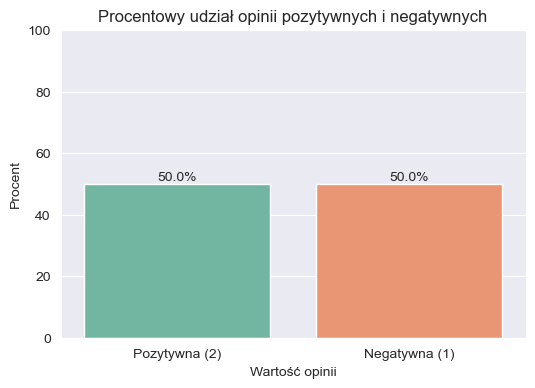

In [143]:
opinion_counts = train_df['opinion'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=opinion_counts.index, y=opinion_counts.values, palette='Set2', hue=opinion_counts.index, legend=False)

for i, percentage in enumerate(opinion_counts.values):
    ax.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', fontsize=10)

plt.title('Procentowy udział opinii pozytywnych i negatywnych')
plt.xlabel('Wartość opinii')
plt.ylabel('Procent')
plt.xticks(ticks=[0, 1], labels=['Pozytywna (2)', 'Negatywna (1)'])
plt.ylim(0, 100)
plt.show()

Wykresy pokazujące ilość wystąpień poszczególnych słów w opiniach. Wykresy przedstawiają wystąpienia słów jedynie po tokenizacji oraz po pełnym przetwrzaniu z podziałem na sentyment.

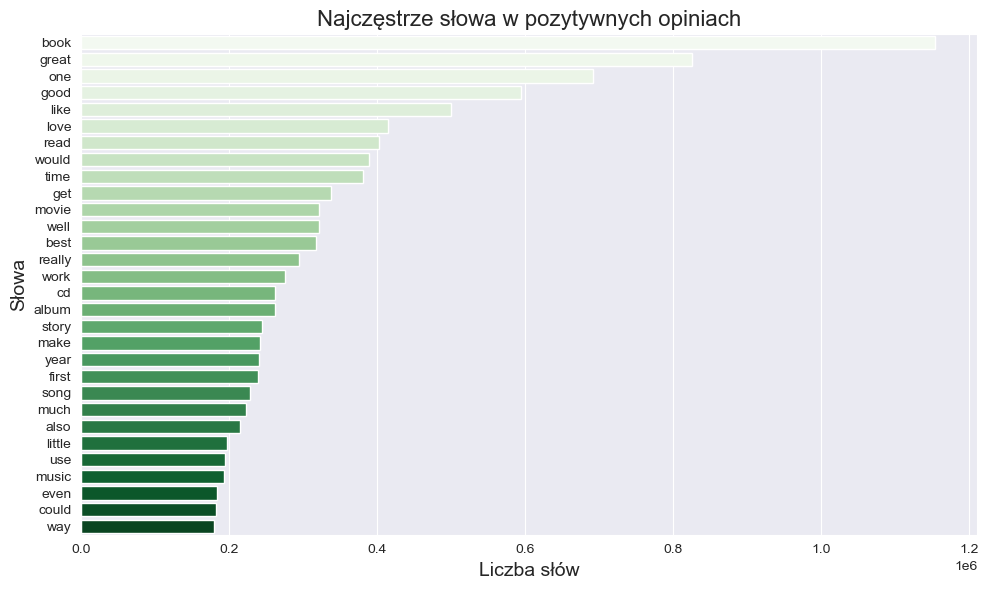

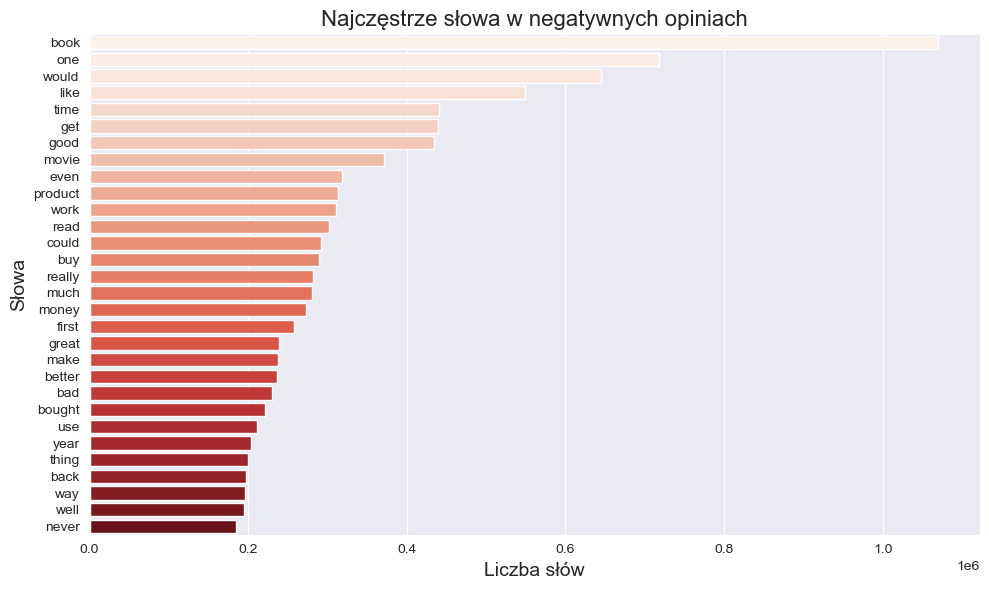

In [226]:
# Najczęstsze słowa dla pozytywnych i negatywnych recenzji

positive_words_counter = Counter(positive_words_list).most_common(30)
negative_words_counter = Counter(negative_words_list).most_common(30)

def plot_most_common_words(common_words, sentiment, color):
    words, counts = zip(*common_words)  # Rozpakowanie słów i ich zliczeń
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette=color, hue=list(words), legend=False)
    plt.title(f'Najczęstrze słowa w {sentiment} opiniach', fontsize=16)
    plt.xlabel('Liczba słów', fontsize=14)
    plt.ylabel('Słowa', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_most_common_words(positive_words_counter, 'pozytywnych', 'Greens')
plot_most_common_words(negative_words_counter, 'negatywnych', 'Reds')

### 4.2 - Analiza *n*-gramów

In [159]:
def get_ngrams(corpus, ngram_range=(2,2)):
    vec = CountVectorizer(
    ngram_range=ngram_range,
    min_df=5,
    max_features=1000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq

In [214]:
def plot_ngrams(ngrams, sentiment, color, ngram='n', n=30):
    ngrams = ngrams[:n]
    combinations_, counts = zip(*ngrams)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=combinations_, palette=color, hue=counts, legend=False)
    plt.title(f'Najczęstrze {ngram}-gramy w {sentiment} opiniach', fontsize=16)
    plt.xlabel('Częstotliwość', fontsize=14)
    plt.ylabel(f'{ngram}-gramy', fontsize=14)
    plt.tight_layout()
    plt.show()

In [215]:
two_grams_positive = get_ngrams(positive_reviews, ngram_range=(2,2))

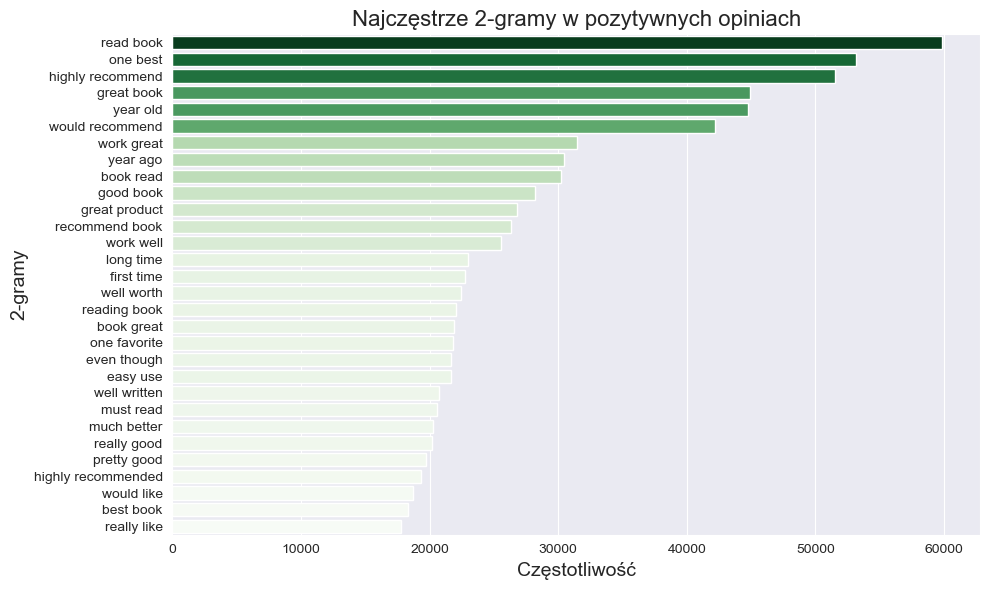

In [216]:
plot_ngrams(two_grams_positive, 'pozytywnych', 'Greens', ngram='2')

In [219]:
two_grams_negative = get_ngrams(negative_reviews, ngram_range=(2,2))

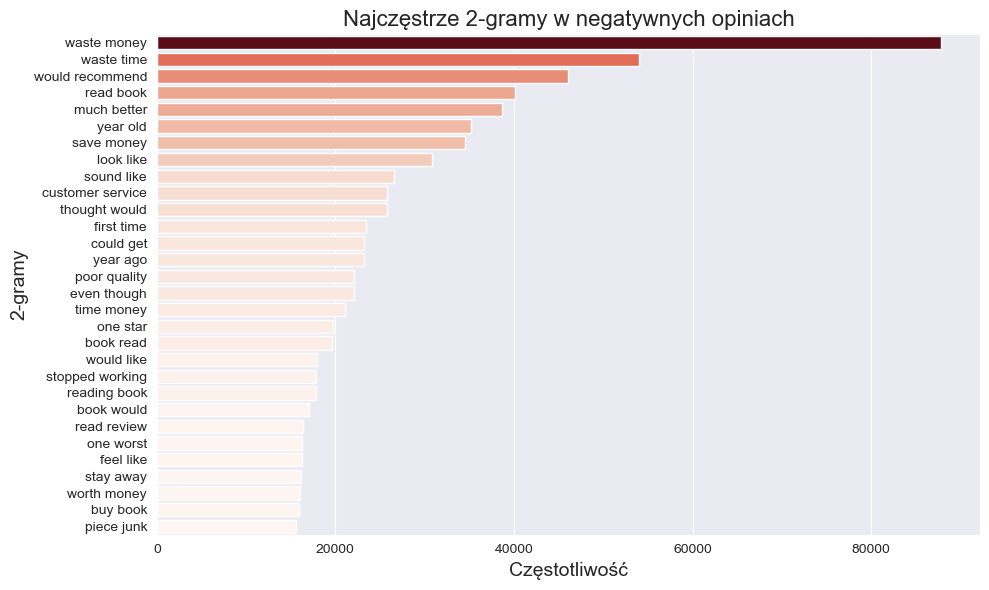

In [220]:
plot_ngrams(two_grams_negative, 'negatywnych', 'Reds', ngram='2')

In [221]:
three_grams_positive = get_ngrams(positive_reviews, ngram_range=(3,3))

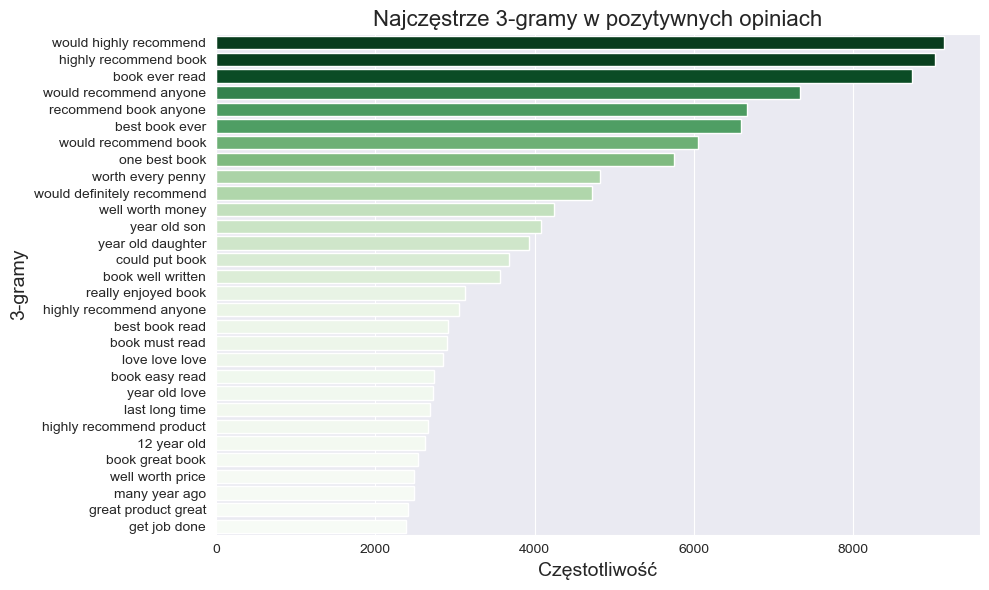

In [222]:
plot_ngrams(three_grams_positive, 'pozytywnych', 'Greens', ngram='3')

In [223]:
three_grams_negative = get_ngrams(negative_reviews, ngram_range=(3,3))

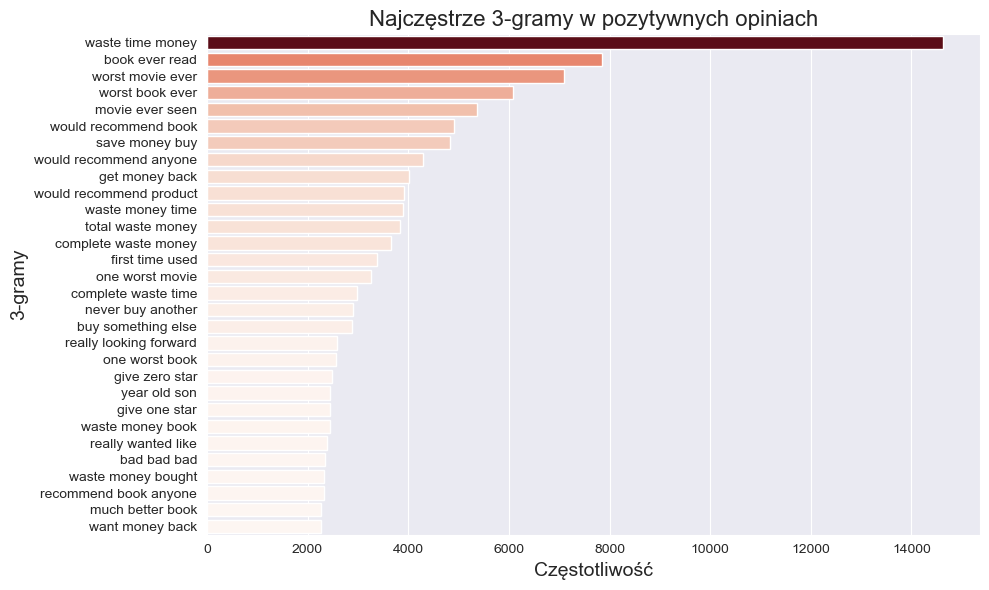

In [224]:
plot_ngrams(three_grams_negative, 'negatywnych', 'Reds', ngram='3')

---
# 5 - TF-IDF

Wybranie optymalnych parametrów dla *TF-IDF*.

Wybranie 10% zbioru danych treninigowych do wybrania parametrów *TF-IDF*

In [59]:
X_sample, X_rest, y_sample, y_rest = train_test_split(
    proc_train_df['full_lematized'],
    proc_train_df['opinion'],
    train_size=0.1,
    random_state=42,
    stratify=proc_train_df['opinion']  # klucz do uzyskania reprezentatywnej próbki
)

Sprawdzenie skuteczności różnych wartości parametrów *TF-IDF* przy użyciu prostego klasyfikatora regresji logistycznej.

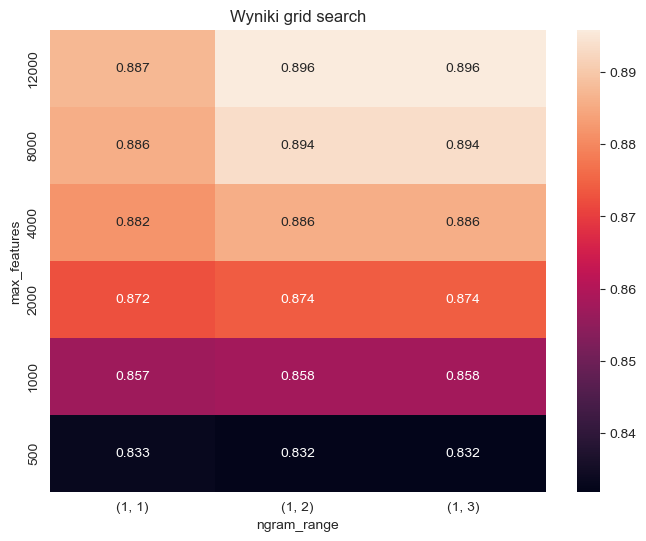

In [26]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=200))
])

param_grid = {
    'tfidf__max_features': [500, 1_000, 2_000, 4_000, 8_000, 12_000],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_sample, y_sample)

results = pd.DataFrame(grid.cv_results_)

# Tabela przestawna
pivot_table = results.pivot(
    index='param_tfidf__max_features',
    columns='param_tfidf__ngram_range',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".3f"
)

plt.xlabel("ngram_range")
plt.ylabel("max_features")
plt.title("Wyniki grid search")
plt.gca().invert_yaxis()
plt.show()

In [36]:
best_tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1,2)
)

# 6 - Modele

Przypisanie nowych nazw na elementy zbioru treningowego i testowego.

In [31]:
X_train, X_test, y_train, y_test = proc_train_df['full_lematized'], proc_test_df['full_lematized'], proc_train_df['opinion'], proc_test_df['opinion']

Wybranie 10% zbioru do dostrajania parametrów. Fragmenty "sample" posłużą do analizy efektywności wybranych parametrów.

In [32]:
X_sample, X_rest, y_sample, y_rest = train_test_split(
    X_train,
    y_train,
    train_size=0.1,
    random_state=42,
    stratify=y_train  # klucz do uzyskania reprezentatywnej próbki
)

Utworzenie gotowych macierzy *tf-idf*, aby przyspieszyć proces badania klasyfikatorów. Parametry wektoryzatora *tf-idf* zostały wybrane w sekcji piątej.

In [37]:
X_sample_tfidf = best_tfidf.fit_transform(X_sample)

In [40]:
X_train_tfidf = best_tfidf.fit_transform(X_train)

In [41]:
X_test_tfidf = best_tfidf.transform(X_test)

Główna funkcja do testowania róznych parametrów wybranego klasyfikatora oraz jego ewaluacji na zbiorze treningowym lub testowym.

In [69]:
def tune_and_evaluate_model(
    model,
    X_train, y_train,
    X_test,  y_test,
    param_grid,
    tfidf_vectorizer,
    tfidf_train_matrix=None,
    tfidf_test_matrix=None,
    tune_split_percentage=0.1,
    cv=3,
    n_jobs=-1,
    tolerance=0.005,
    n=3,
    evaluate_train=False,
    evaluate_test=True,
    return_best_params_only=False,
    labels=None
):
    # 1) Walidacja podania tfidf_train_matrix vs tfidf_test_matrix
    if (tfidf_train_matrix is None) ^ (tfidf_test_matrix is None):
        raise ValueError(
            "Jeśli podajesz macierz tfidf, to musisz podać JEDNOCZEŚNIE "
            "zarówno `tfidf_train_matrix`, jak i `tfidf_test_matrix`."
        )
    # 2) Jeżeli nie ma macierzy, budujemy je z X_train/X_test
    if tfidf_train_matrix is None:
        tfidf_train_matrix = tfidf_vectorizer.fit_transform(X_train)
        tfidf_test_matrix  = tfidf_vectorizer.transform(X_test)

    # 3) Wyciągamy próbkę do szybszego tuningu
    X_sample, _, y_sample, _ = train_test_split(
        X_train, y_train,
        train_size=tune_split_percentage,
        random_state=42,
        stratify=y_train
    )

    # 4) Tuning parametrów
    best_params = find_best_params(
        model=model,
        X_sample=X_sample, y_sample=y_sample,
        param_grid=param_grid,
        tfidf_vectorizer=tfidf_vectorizer,
        cv=cv, n_jobs=n_jobs,
        tolerance=tolerance, n=n
    )
    # jeżeli chcemy tylko parametry
    if return_best_params_only:
        return best_params

    # 5) Ustawiamy najlepsze parametry i fitujemy na całym train
    model = model.set_params(**best_params)
    model.fit(tfidf_train_matrix, y_train)
    labels = model.classes_

    # 6) Ewaluacja wg flag
    if evaluate_train:
        print("\n=== Ewaluacja na zbiorze treningowym ===")
        evaluate_model(model, tfidf_train_matrix, y_train, labels=labels)

    if evaluate_test:
        print("\n=== Ewaluacja na zbiorze testowym ===")
        evaluate_model(model, tfidf_test_matrix, y_test, labels=labels)

    return model, best_params


Funkcja zajmująca się wyłacznie wyborem najlepszych parametrów wybranego klasyfikatora.

In [62]:
def find_best_params(model, X_sample, y_sample, param_grid, tfidf_vectorizer=None, cv = 3, n_jobs = -1, tolerance = 0.005, n = 3):

    if tfidf_vectorizer is None:
        pipeline = Pipeline([
            ('clf', model)
        ])
    else:
        pipeline = Pipeline([
            ('tfidf', tfidf_vectorizer),
            ('clf', model)
        ])

    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=cv,   # cross-validation
        scoring='accuracy',
        n_jobs=n_jobs
    )

    grid.fit(X_sample, y_sample)
    results_df = pd.DataFrame(grid.cv_results_)

    param_names = list(param_grid.keys())
    param_cols  = [f'param_{p}' for p in param_names]

    plot_cv_results_heatmap(
        cv_results_df=results_df,
        param_x       = param_cols[0],   # 'param_clf__C'
        param_y       = param_cols[1],   # 'param_clf__penalty'
        score_col     = 'mean_test_score',
        xlabel        = param_names[0].split('__')[-1], # 'C'
        ylabel        = param_names[1].split('__')[-1], # 'penalty'
        invert_yaxis=True,
        cmap='Blues'
    )

    # Wyniki
    print("Bezwględnie najlepsze parametry:", grid.best_params_)
    print("Bezwględnie najlepszy wynik CV:", grid.best_score_)

    best = results_df['mean_test_score'].max()

    candidates = results_df[
        results_df['mean_test_score'] <= best - tolerance
        ].sort_values('rank_test_score')

    print()
    print(f'Top {n} po uwzględnieniu tolerancji')
    print(candidates[['params', 'mean_test_score', 'rank_test_score']].iloc[:3])

    temp_best = candidates['params'].iloc[0]
    result_best_params = {}
    for key in temp_best.keys():
        if key.startswith('clf__'):
            result_best_params[key.split('__')[-1]] = temp_best[key]

    return result_best_params

Funkcja zajmująca się ewaluacją wybranego klasyfikatora oraz przedstawieniem wyników w formie graficznej i tekstowej. Tworzona jest macierz pomyłek oraz wypisywane jest *classification_report*.

In [47]:
def evaluate_model(model, X_test, y_test, labels=None):

    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    report = classification_report(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm,
        annot=True,
        fmt="d",
        cbar=False,
        xticklabels=labels,
        yticklabels=labels)
    plt.title("Macierz pomyłek")
    plt.xlabel("Przewidziane wartości")
    plt.ylabel("Wartości prawdziwe")
    plt.show()

    print("Classification Report:")
    print(report)

    return cm, report

In [38]:
def plot_cv_results_heatmap(cv_results_df,
                            param_x,
                            param_y,
                            score_col='mean_test_score',
                            xlabel='Param X',
                            ylabel='Param Y',
                            title='Wyniki grid search',
                            invert_yaxis=False,
                            cmap='viridis'
                            ):

    pivot_table = cv_results_df.pivot(
        index=param_y,
        columns=param_x,
        values=score_col
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap=cmap)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    if invert_yaxis:
        plt.gca().invert_yaxis()

    plt.show()

## 6.1 - Regresja

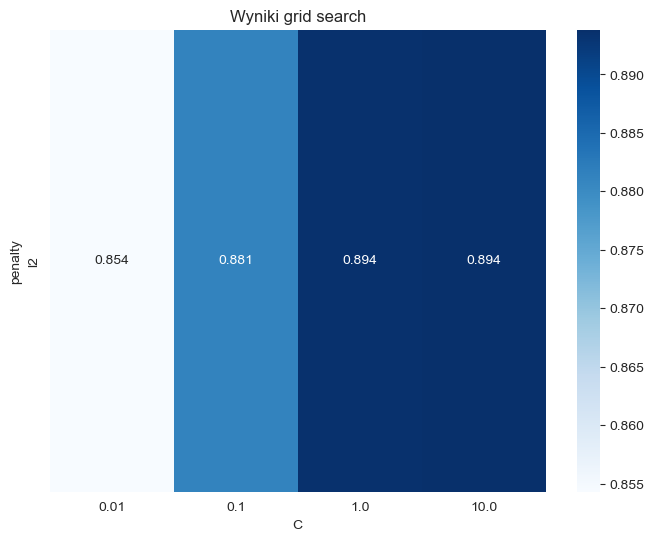

Bezwględnie najlepsze parametry: {'clf__C': 10.0, 'clf__penalty': 'l2'}
Bezwględnie najlepszy wynik CV: 0.8938225061581729

Top 3 po uwzględnieniu tolerancji
                                   params  mean_test_score  rank_test_score
1   {'clf__C': 0.1, 'clf__penalty': 'l2'}         0.881265                3
0  {'clf__C': 0.01, 'clf__penalty': 'l2'}         0.854316                4

=== Ewaluacja na zbiorze testowym ===


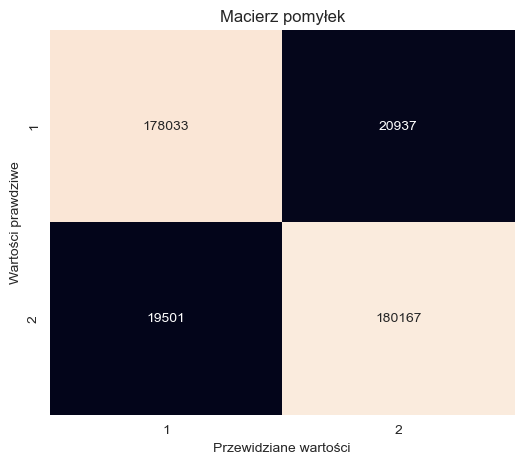

Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.89      0.90    198970
           2       0.90      0.90      0.90    199668

    accuracy                           0.90    398638
   macro avg       0.90      0.90      0.90    398638
weighted avg       0.90      0.90      0.90    398638



(LogisticRegression(C=0.1), {'C': 0.1, 'penalty': 'l2'})

In [70]:
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__penalty': ['l2']
}
tune_and_evaluate_model(LogisticRegression(), X_train, y_train, X_test, y_test, param_grid, best_tfidf, tfidf_train_matrix=X_train_tfidf, tfidf_test_matrix=X_test_tfidf)

## 6.2 - *k-NN*

In [37]:
pipeline_knn = Pipeline([
    ('tfidf', best_tfidf),
    ('clf', KNeighborsClassifier())
])

param_grid_knn = {
    'clf__n_neighbors': [3, 5, 7],
    'clf__weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(
    pipeline_knn,
    param_grid=param_grid_knn,
    cv=3,   # cross-validation
    scoring='accuracy',
    n_jobs=-1
)

grid_knn.fit(X_sample, y_sample)
results_knn_df = pd.DataFrame(grid_knn.cv_results_)

print("Najlepsze parametry (k-NN):", grid_knn.best_params_)
print("Najlepszy wynik CV (k-NN):", grid_knn.best_score_)

KeyboardInterrupt: 

In [ ]:
plot_cv_results_heatmap(
    cv_results_df=results_df,
    param_x='param_clf__C',
    param_y='param_clf__penalty',
    score_col='mean_test_score',
    xlabel='C',
    ylabel='penalty',
    invert_yaxis=True,
    cmap='Blues'
)

In [ ]:
pipeline_final = Pipeline([
    ('clf', KNeighborsClassifier())
])

trained_pipeline = pipeline_final.fit(x_train_tfidf, y_train)
cm, report = evaluate_model(trained_pipeline, x_test_tfidf, y_test, labels=[1, 2])

## 6.3 - drzewo decyzyjne

In [41]:
pipeline_dt = Pipeline([
    ('tfidf', best_tfidf),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    'clf__max_depth': [5, 10, 20],
    'clf__min_samples_split': [2, 5, 10]
}

grid_dt = GridSearchCV(
    pipeline_dt,
    param_grid=param_grid_dt,
    cv=2,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_dt.fit(X_sample, y_sample)
results_dt_df = pd.DataFrame(grid_dt.cv_results_)

print("Najlepsze parametry (Decision Tree):", grid_dt.best_params_)
print("Najlepszy wynik CV (Decision Tree):", grid_dt.best_score_)


Fitting 2 folds for each of 9 candidates, totalling 18 fits
Najlepsze parametry (Decision Tree): {'clf__max_depth': 20, 'clf__min_samples_split': 5}
Najlepszy wynik CV (Decision Tree): 0.7579355038265833


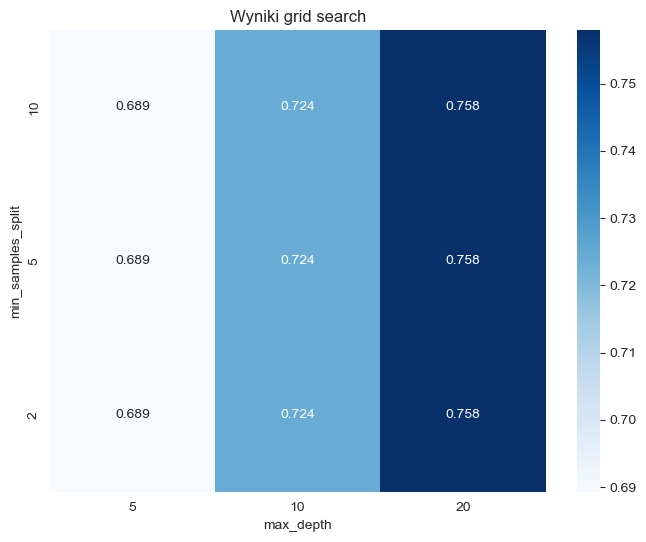

In [45]:
plot_cv_results_heatmap(
    cv_results_df=results_dt_df,
    param_x='param_clf__max_depth',
    param_y='param_clf__min_samples_split',
    score_col='mean_test_score',
    xlabel='max_depth',
    ylabel='min_samples_split',
    invert_yaxis=True,
    cmap='Blues'
)